# Neural Networks
Content:
- **Linear Regression**
    - using sklearn
    - normal equation
    - as numerical optimization problem
    - as neural network
-  **Intuition behind Neural Networks**
-  **The universal approximation Theorem**

In [1]:
!pip install torch
!pip install numpy
!pip install pandas

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import datasets

### Linear Regression
- Todo unify shapes of coefficients to make smooth experience

In [3]:
def load_diabetes():
    x_columns = {'bp': 'bloodPressure', 
                 'bmi': 'bodyMassIndex',
                 's1': 'totalSerumCholesterol', 
                 's2': 'lowDensityLipoproteins',
                 's3': 'highDensityLipoproteins',
                 's4': 'totalCholesterol',
                 's5': 'serumTriglyceridesLevel',
                 's6': 'bloodSugarLevel'}
    x, y = datasets.load_diabetes(return_X_y=True, as_frame=True)
    x = x.rename(columns=x_columns)
    y = pd.DataFrame({'diseaseProgression': y})
    return x, y


def split_test_train(x, y):
    return 1/0


### Load Data and visualize
**Todo**: decide on data set

Text(0, 0.5, 'Disease Progression')

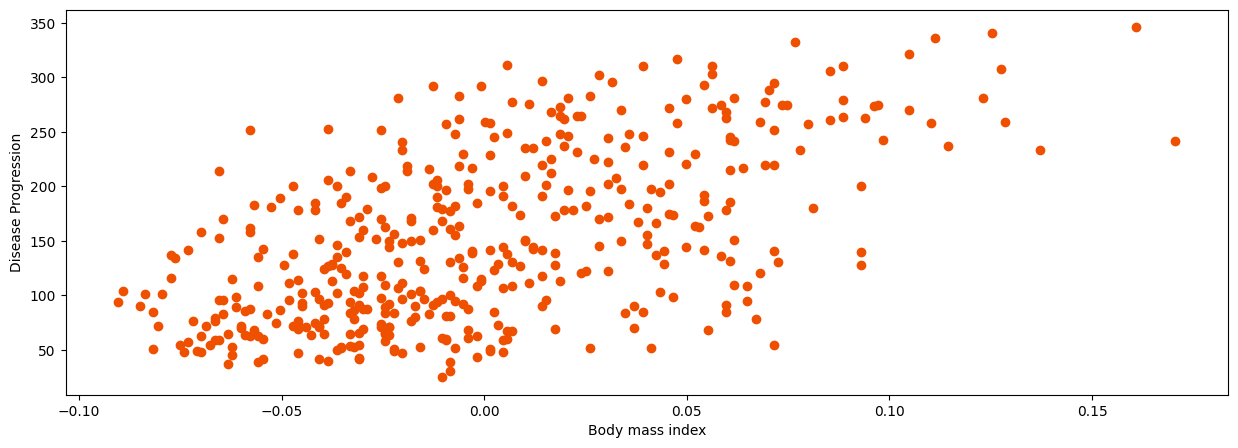

In [4]:
x, y = load_diabetes()

# Todo test train split
x_train, y_train = x, y
x_test, y_test = x, y

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')


# Linear Regression
### Linear Regression using Sklearn

In [5]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(x_train[['bodyMassIndex']], y_train)
print(f"Intercept {regr.intercept_[0]}, Coefficient {regr.coef_[0,0]} ")
x_pred = x_test[['bodyMassIndex']].sort_values(by='bodyMassIndex')
y_pred = regr.predict(x_pred)

Intercept 152.13348416289617, Coefficient 949.4352603840388 


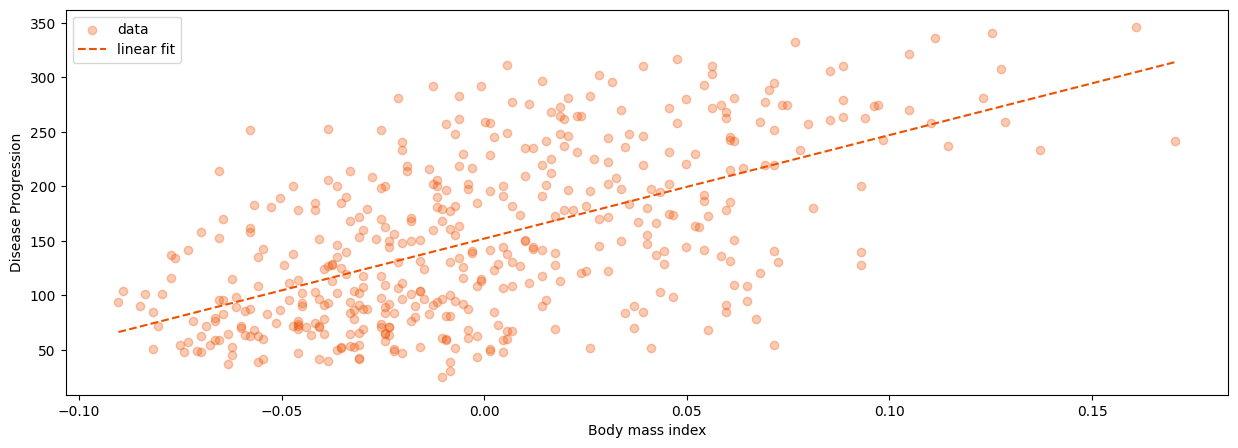

In [6]:

fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000', alpha=.3, label='data')
ax.plot(x_pred, y_pred, '--',  color='#ef5000', label = 'linear fit')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')
ax.legend()

### Linear Regression using the normal equation
The normal equation is a closed form solution of the linear regression problem. It gives the fit coefficients $\alpha$ in terms of matrix mulitplication.
Once the coefficients are calculated a prediction $\hat y$ can be made.

$$\alpha = (x^Tx)^{-1} x^T y$$
$$\hat y = \alpha^T x$$

In [7]:
def add_intercept(x):
    return x.assign(intercept = 1)
    
def fit_normal_equation(x, y):
    x_t = x.transpose()
    inverse = np.linalg.inv(x_t @ x)
    alpha = inverse @ x_t @ y
    return alpha

def predict_normal_equation(alpha, x):
    print (alpha.shape, x.shape)
    return x @ alpha
    

In [8]:
x_fit = add_intercept(x_train)[['intercept', 'bodyMassIndex']].values
y_fit = y_train.values
alpha = fit_normal_equation(x_fit, y_fit)
print(f"Intercept {alpha[0, 0]}, Coefficient {alpha[1,0]} ")
x_pred = add_intercept(x_test)[['intercept', 'bodyMassIndex']].sort_values(by='bodyMassIndex').values
y_pred = predict_normal_equation(alpha, x_pred)

Intercept 152.13348416289617, Coefficient 949.4352603840387 
(2, 1) (442, 2)


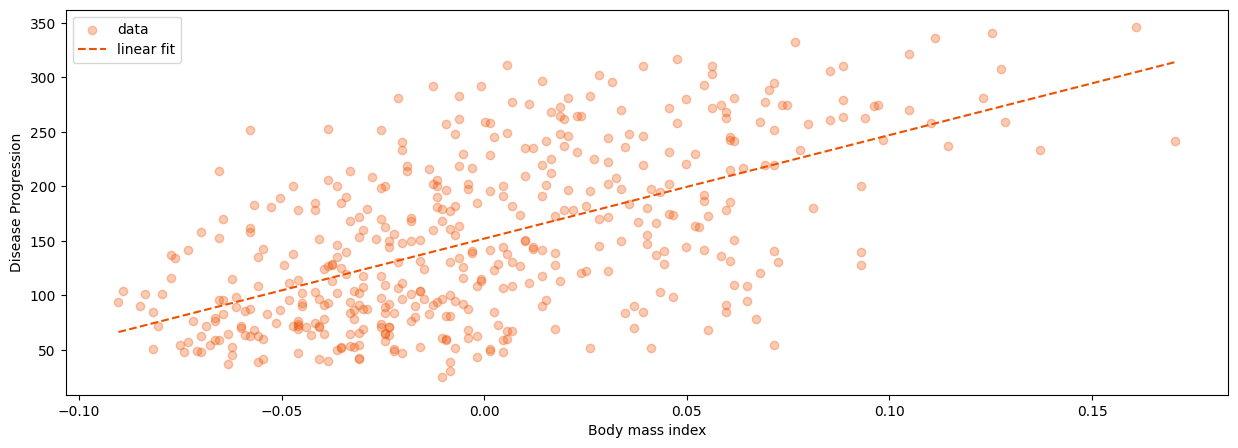

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
ax.scatter(x_train.bodyMassIndex, y, color='#ef5000', alpha=.3, label='data')
ax.plot(x_pred[:, 1], y_pred, '--',  color='#ef5000', label = 'linear fit')
ax.set_xlabel('Body mass index')
ax.set_ylabel('Disease Progression')
ax.legend()


### Linear Regression as numerical optimization problem

In [10]:
from scipy import optimize

def reshape_alpha(alpha):
    return alpha[..., np.newaxis] 


def f(alpha):
    a = reshape_alpha(alpha)
    loss =  (x_fit @ a - y_fit)**2
    return loss.sum()

 
opt = optimize.minimize(f, np.array([0, 0]), method='nelder-mead')
alpha = reshape_alpha(opt['x'])
print(f"Intercept {alpha[0, 0]}, Coefficient {alpha[1,0]} ")

Intercept 152.13348218121047, Coefficient 949.4352653323601 


### Linear Regression as Neural Network

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim

class LinearRegressionModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1) 

    def forward(self, x):
        return self.linear(x)

In [125]:
model = LinearRegressionModel()
criterion = nn.MSELoss()  # Mean Squared Error loss function
optimizer = optim.SGD(model.parameters(), lr=0.5)  # Stochastic Gradient Descent

x_fit_torch = torch.from_numpy(x_train[['bodyMassIndex']].values).to(torch.float32)
y_fit_torch = torch.from_numpy(y_train[['diseaseProgression']].values).to(torch.float32)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100000, gamma=0.)

# Training loop
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass: compute prediction and loss
    y_pred = model(x_fit_torch)
    loss = criterion(y_pred, y_fit_torch)
    
    # Backward pass: compute gradients and update weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    
    # Print loss every 100 epochs
    if (epoch+1) % 100 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f},  intercept: {model.linear.bias.data[0]}, Coefficient {model.linear.weight.data[0, 0]}')

Epoch 100/5000, Loss: 5191.4644,  intercept: 152.13348388671875, Coefficient 192.83343505859375
Epoch 200/5000, Loss: 4717.5293,  intercept: 152.13348388671875, Coefficient 346.18243408203125
Epoch 300/5000, Loss: 4416.2407,  intercept: 152.13348388671875, Coefficient 468.450439453125
Epoch 400/5000, Loss: 4224.7070,  intercept: 152.13348388671875, Coefficient 565.9369506835938
Epoch 500/5000, Loss: 4102.9453,  intercept: 152.13348388671875, Coefficient 643.6648559570312
Epoch 600/5000, Loss: 4025.5393,  intercept: 152.13348388671875, Coefficient 705.6388549804688
Epoch 700/5000, Loss: 3976.3311,  intercept: 152.13348388671875, Coefficient 755.0518798828125
Epoch 800/5000, Loss: 3945.0486,  intercept: 152.13348388671875, Coefficient 794.4496459960938
Epoch 900/5000, Loss: 3925.1614,  intercept: 152.13348388671875, Coefficient 825.8621826171875
Epoch 1000/5000, Loss: 3912.5193,  intercept: 152.13348388671875, Coefficient 850.908203125
Epoch 1100/5000, Loss: 3904.4819,  intercept: 152.13